In [1]:
import hydra
from glob import  glob
from rosa.data import  RosaDataModule, create_io_paths
from rosa.modeling import  RosaLightningModule
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/rosa/conf/" # /Users/nsofroniew/Documents/GitHub/ or /home/ec2-user/
# BASE_DIR = "/home/ec2-user/outputs/2023-05-02/16-41-31"
BASE_DIR = "/home/ec2-user/outputs/2023-05-09/05-06-40"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[1]
    print('   Using ', chkpt)

    _, output_path = create_io_paths(config.paths)

    # config.data_module.data.mask = 0.01
    # config.data_module.data.n_var_sample = 1000
    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()
    print(output_path)

    rdm.setup()

    adata = rdm.val_dataset.adata
    obs_indices = rdm.val_dataset.obs_indices.detach().numpy()
    var_bool = rdm.val_dataset.mask_bool.detach().numpy()
    adata_predict = adata[obs_indices, var_bool]
    # counts = rdm.train_dataset.counts.mean(dim=1)
    # counts = torch.bincount(rdm.train_dataset.expression.ravel(), minlength=rdm.train_dataset.n_bins)

    rlm = RosaLightningModule.load_from_checkpoint(
        chkpt,
        var_input=rdm.var_input,
        config=config.module,
        adata=adata_predict,
        weight=None,  # 1 / counts,
    )
    print(rlm)

/tmp/ipykernel_10348/3484952289.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/2023-05-09/05-06-40/checkpoints/epoch=4-step=48000.ckpt
/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type.h5ad
RosaLightningModule(
  (model): RosaTransformer(
    (expression_embedding): BinnedEmbed(
      (model): Sequential(
        (embedding): Embedding(9, 1024)
        (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (var_embedding): LinearEmbed(
      (model): Sequential(
        (pre_layer_norm): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=3072, out_features=1024, bias=True)
        (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (transformer): PerceiverIO(
      (cross_attend_blocks): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_q): Linear(in_features=512, out_f

In [3]:
print(f'Train samples {len(rdm.train_dataset)}, Val samples {len(rdm.val_dataset)}, {adata.shape[1]} genes')

Train samples 338267, Val samples 144885, 19431 genes


In [9]:
import numpy as np

model_parameters = filter(lambda p: p.requires_grad, rlm.model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'{params/1e6:.2f} Million paramters')

49.00 Million paramters


In [6]:
params / 1e6

49.003528

In [2]:
dl = iter(rdm.val_dataloader())

In [116]:
import torch
from rosa.utils.helpers import sample
from torchmetrics.functional import spearman_corrcoef


batch = next(dl)
orginial_mask = batch["mask"].detach().clone()
batch_size = orginial_mask.shape[0]
n_mask = orginial_mask.sum(dim=1)
batch["var_input"] = rlm.var_input[0, batch["var_indices"]]

for i in range(60):
    expression_predicted_full = rlm(batch)
    
    if i == 0:
        expression_predicted_original = expression_predicted_full.detach().clone()

    expression_predicted = expression_predicted_full[orginial_mask]
    expression = batch["expression_target"][orginial_mask]
    predicted, confidence = sample(expression_predicted, nbins=rlm.n_bins)

    loss = rlm.criterion(expression_predicted, expression)
    s_loss = spearman_corrcoef(predicted.float(), expression.float())
    print(f'Round {i} loss {loss:.3f} and {s_loss:.3f} with {batch["mask"].sum()} masked')

    expression_predicted = expression_predicted_full[batch["mask"]]
    expression = batch["expression_target"][batch["mask"]]
    predicted, confidence = sample(expression_predicted, nbins=rlm.n_bins)

    if len(expression) > 0:
        loss = rlm.criterion(expression_predicted, expression)
        s_loss = spearman_corrcoef(predicted.float(), expression.float())
        print(f'   Round {i} loss {loss:.3f} and {s_loss:.3f} with {batch["mask"].sum()} masked')

        expression_predicted = expression_predicted_original[batch["mask"]]
        expression = batch["expression_target"][batch["mask"]]
        predicted_orig, confidence = sample(expression_predicted, nbins=rlm.n_bins)
        loss = rlm.criterion(expression_predicted, expression)
        s_loss = spearman_corrcoef(predicted_orig.float(), expression.float())
        print(f'   Orig Round {i} loss {loss:.3f} and {s_loss:.3f} with {batch["mask"].sum()} masked')
        print(f'   Orig diff {(predicted_orig != predicted).sum()} out of {len(predicted)}')


    k = 100
    if len(confidence) > k:
        vals, indices = torch.topk(confidence, k)
        # indices = torch.randperm(len(confidence))[:k]
    else:
        indices = torch.arange(len(confidence))

    mask_indices = torch.where(batch["mask"])[1]
    # print(batch["mask"][0, mask_indices[indices]].unique())
    batch["mask"][0, mask_indices[indices]] = False
    # print(batch['expression_input'][0, mask_indices[indices]].unique())
    batch['expression_input'][0, mask_indices[indices]] = predicted[indices]


# predicted, _ = sample(expression_predicted, nbins=self.n_bins)
# spearman_obs_mean = 1 - spearman_corrcoef(predicted.T.float(), expression.T.float()).mean()
# spearman_var_mean = 0.0
# spearman_var_mean = 1 - spearman_corrcoef(predicted.float(), expression.float()).mean()
# beta_obs_loss = 1.0
# beta_var_loss = 1.0

# expression = expression[batch["mask"]]
# loss = rlm.criterion(expression_predicted, expression)

Round 0 loss 0.755 and 0.880 with 5792 masked
   Round 0 loss 0.755 and 0.880 with 5792 masked
   Orig Round 0 loss 0.755 and 0.880 with 5792 masked
   Orig diff 0 out of 5792
Round 1 loss 0.749 and 0.881 with 5692 masked
   Round 1 loss 0.761 and 0.877 with 5692 masked
   Orig Round 1 loss 0.766 and 0.876 with 5692 masked
   Orig diff 179 out of 5692
Round 2 loss 0.748 and 0.880 with 5592 masked
   Round 2 loss 0.771 and 0.874 with 5592 masked
   Orig Round 2 loss 0.778 and 0.874 with 5592 masked
   Orig diff 199 out of 5592
Round 3 loss 0.747 and 0.881 with 5492 masked
   Round 3 loss 0.781 and 0.872 with 5492 masked
   Orig Round 3 loss 0.789 and 0.871 with 5492 masked
   Orig diff 247 out of 5492
Round 4 loss 0.744 and 0.882 with 5392 masked
   Round 4 loss 0.789 and 0.871 with 5392 masked
   Orig Round 4 loss 0.801 and 0.869 with 5392 masked
   Orig diff 181 out of 5392
Round 5 loss 0.738 and 0.881 with 5292 masked
   Round 5 loss 0.788 and 0.869 with 5292 masked
   Orig Round 5 l

In [112]:
expression.dtype

torch.int64

In [49]:
mask_indices = torch.where(batch["mask"])[1]

In [50]:
len(mask_indices)

5792

In [53]:
mask_indices[indices]

tensor([12171, 18769, 19088, 18056, 18764, 13768, 19178, 15503, 18775, 16773,
        15139, 19186, 19083, 18559, 17988, 18584, 16623, 17362, 14920, 17208,
        12192, 18586, 13367, 14374, 17209, 18471, 14061, 15499, 17307, 18765,
        18071, 14742, 19061, 17905, 16673, 16853, 15506,  3644, 17779, 19055,
        18481, 17657, 14059,  8709, 19284, 15360, 18406,  4395, 18575, 14280,
        18673, 18887, 15689, 19052, 14592, 18828, 17123,   118, 19333, 14873,
        16662, 18121, 15646, 14584, 14781, 18129,   966, 19293, 16603, 18823,
        18070,  5068, 19302,  4955, 10647, 17138, 17255, 12986, 18029, 15793,
        18090, 18799, 17057,  8710,  2501,  9526, 15997,  3274,  8539, 18025,
        18555, 18787, 16199, 14470,  2657,  5184, 15597, 19006, 19079, 15223,
        17692, 10528, 19301, 18013, 13763,  4928, 18657, 18699, 13039, 17365,
        18777, 14623, 15484, 17489, 10272, 16324, 17210, 18414, 16621,  3801,
        12703,  8048, 19032, 13467, 16046, 18719, 19368,  7171, 

In [52]:
indices

tensor([3567, 5573, 5674, 5345, 5570, 4024, 5697, 4559, 5576, 4938, 4444, 5703,
        5671, 5496, 5313, 5505, 4891, 5125, 4387, 5079, 3572, 5506, 3907, 4217,
        5080, 5470, 4117, 4557, 5111, 5571, 5352, 4336, 5666, 5289, 4905, 4962,
        4561, 1086, 5255, 5664, 5472, 5217, 4115, 2518, 5735, 4514, 5450, 1286,
        5502, 4187, 5539, 5620, 4620, 5662, 4289, 5599, 5053,   36, 5758, 4374,
        4901, 5364, 4605, 4285, 4349, 5367,  279, 5742, 4887, 5596, 5351, 1488,
        5747, 1454, 3092, 5058, 5094, 3805, 5332, 4647, 5358, 5589, 5027, 2519,
         739, 2750, 4705,  973, 2476, 5329, 5495, 5582, 4771, 4251,  791, 1519,
        4586, 5652, 5669, 4471, 5229, 3047, 5746, 5324, 4022, 1442, 5532, 5547,
        3819, 5127, 5577, 4302, 4553, 5163, 2965, 4811, 5081, 5455, 4890, 1132,
        3723, 2342, 5658, 3942, 4723, 5556, 5771, 2109, 5660, 4702, 5331, 5555,
        4708, 5791, 1555, 3613, 4657, 2532, 5283, 4210, 1806, 1712, 5074, 5432,
        5278, 3755, 4126, 5133, 2943, 28

In [36]:
import torch


torch.topk(confidence, 100000)

RuntimeError: selected index k out of range

In [38]:
orginial_mask = batch["mask"].detach().clone()

In [33]:
batch["mask"].sum()

tensor(5792)

In [ ]:
batch["mask"]
batch['expression_input']

In [34]:
batch

{'expression_input': tensor([[1, 8, 8,  ..., 0, 0, 8]]),
 'expression_target': tensor([[1, 0, 1,  ..., 0, 0, 0]]),
 'mask': tensor([[False,  True,  True,  ..., False, False,  True]]),
 'var_indices': tensor([[    0,     1,     2,  ..., 19428, 19429, 19430]]),
 'obs_idx': tensor([4]),
 'var_input': tensor([[[-1.5536e-01, -8.6996e-05, -1.4360e-01,  ..., -1.3952e-04,
           -5.8013e-02, -1.1921e-01],
          [-1.5421e-01, -2.2148e-05, -3.7587e-02,  ..., -1.2347e-03,
           -1.4557e-01,  4.7184e-01],
          [-1.1579e-01, -1.1530e-04,  1.2731e-01,  ..., -7.2026e-06,
           -1.3026e-01, -1.4232e-01],
          ...,
          [-4.9547e-02, -1.7178e-04, -6.8877e-02,  ..., -2.6904e-04,
           -1.5714e-01, -1.5337e-01],
          [-1.6293e-01, -8.0574e-06, -1.0059e-01,  ..., -1.0424e-04,
           -9.4065e-02, -9.8332e-02],
          [-2.0365e-02, -1.1641e-05, -3.9334e-02,  ..., -1.0814e-05,
           -5.6320e-02, -1.1605e-01]]])}

In [20]:
expression_predicted.shape

torch.Size([5792, 8])

In [27]:
confidence[expression == predicted].mean()

tensor(0.7513, grad_fn=<MeanBackward0>)

In [28]:
confidence[expression != predicted].mean()

tensor(0.5199, grad_fn=<MeanBackward0>)

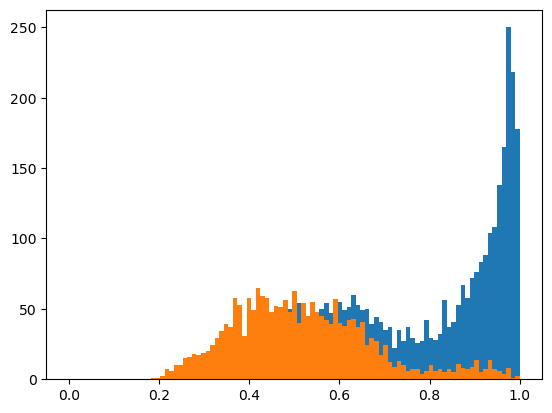

In [32]:
import matplotlib.pyplot as plt
import numpy as np


bins = np.linspace(0, 1, 100)
plt.hist(confidence[expression == predicted].detach().numpy().flatten(), bins);
plt.hist(confidence[expression != predicted].detach().numpy().flatten(), bins);

In [1]:
import anndata as ad

# PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'
PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type__processed.h5ad'

adata_predict = ad.read_h5ad(PATH)
nbins = adata_predict.uns['nbins']
results = adata_predict.uns['results']

In [4]:
adata_predict

AnnData object with n_obs × n_vars = 97 × 5792
    obs: 'dataset_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'label', 'sample', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_label', 'hvg', 'log1p', 'nbins', 'obs_embedding_pca', 'preprocessing', 'rank_genes_groups', 'results', 'var_embedding_pca'
    obsm: 'bin_edges', 'embedding'
    varm: 'embedding', 'embedding_pca'
    layers: 'binned', 'confidence', 'counts', 'log1p', 'normalized_counts', 'predicted', 'target'

In [3]:
print(
    f"""
    mean spearman across genes {results['spearman_obs_mean']:.3f}
    mean spearman across cells {results['spearman_var_mean']:.3f}
    """
)  


    mean spearman across genes 0.594
    mean spearman across cells 0.235
    


In [4]:
# import numpy as np
# cm = results['confusion_matrix']
# print(cm.sum(axis=1))
# X = cm / cm.sum(axis=1)[:, np.newaxis]

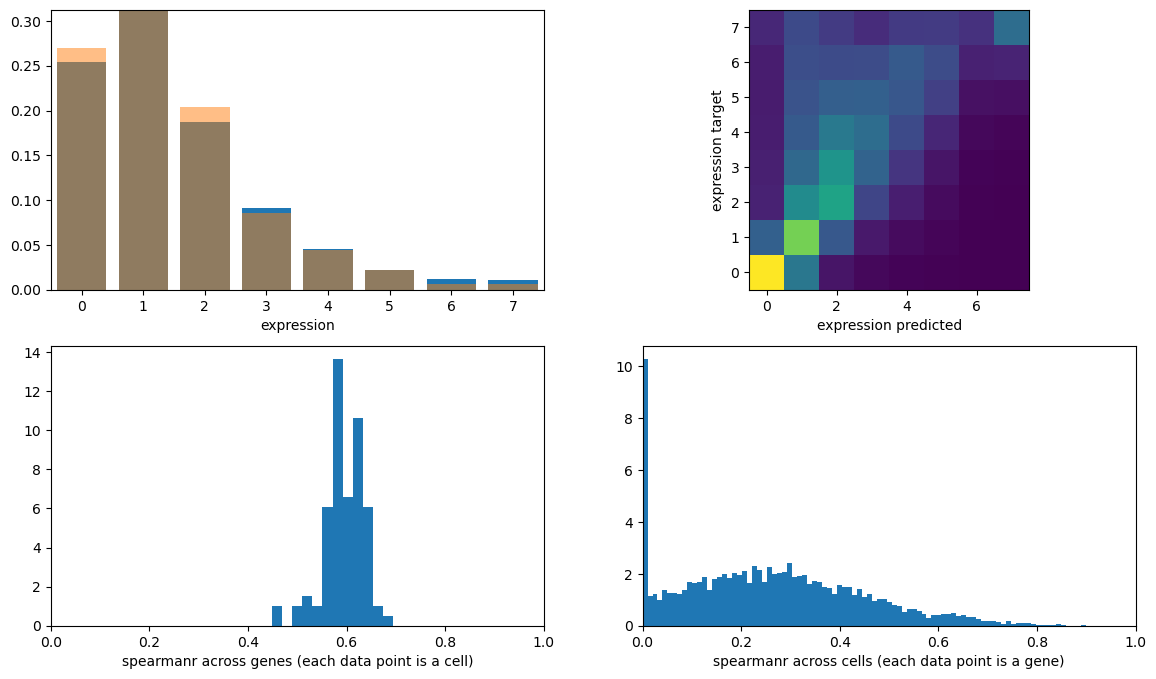

In [5]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap
  
plot_expression_and_correlation(results)

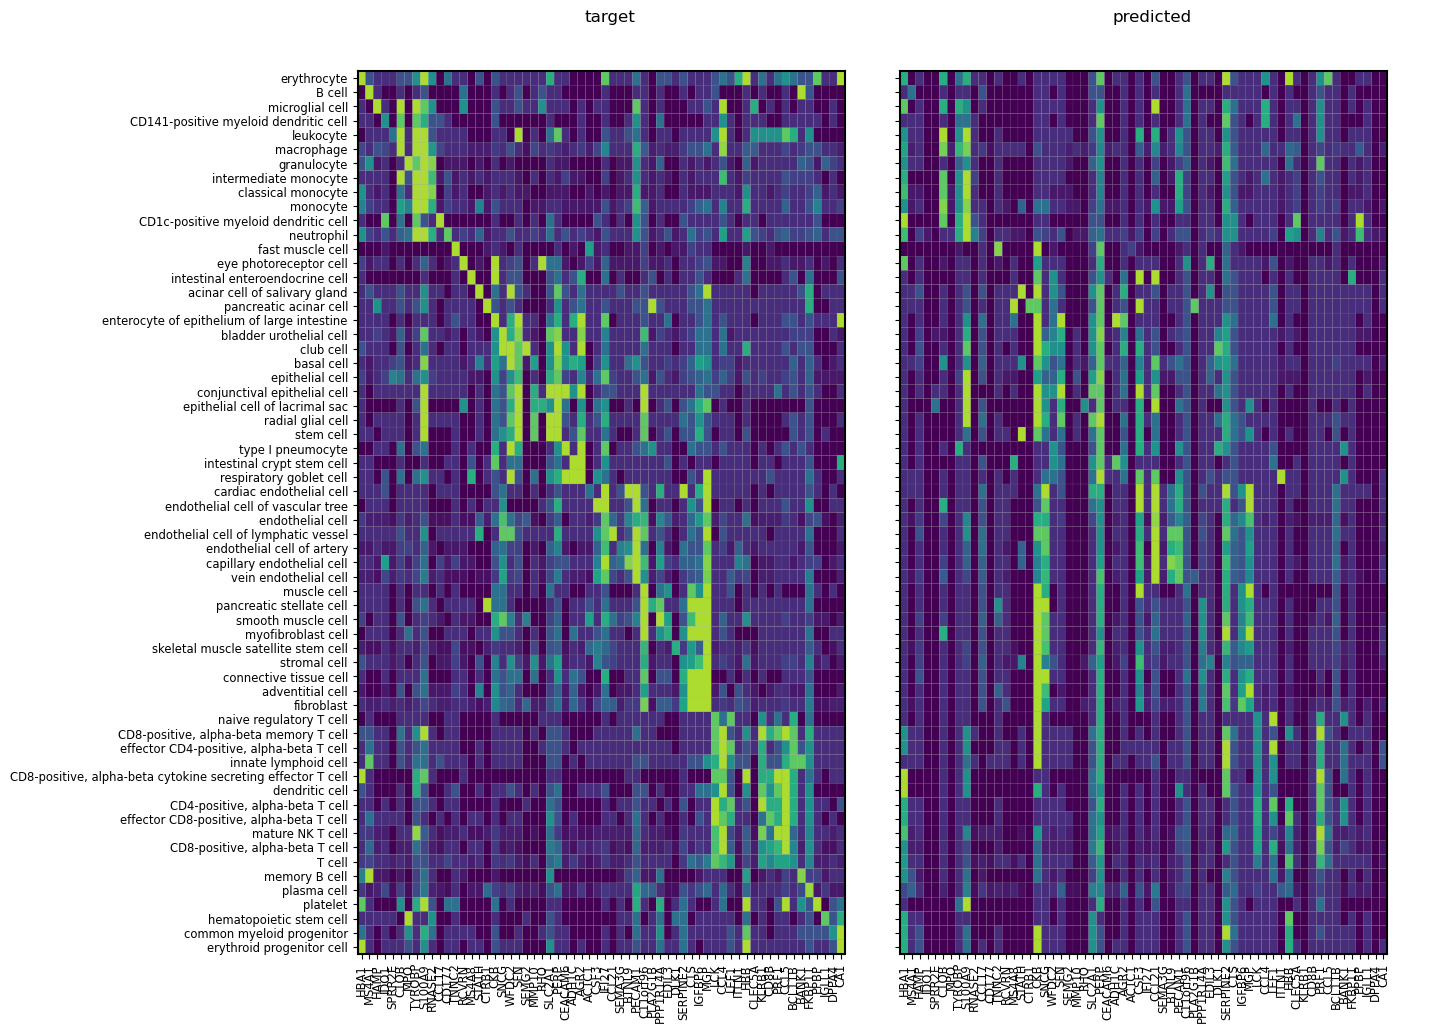

In [51]:
import scanpy as sc

marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
sc.tl.dendrogram(adata_predict, groupby="label", use_rep="X")
plot_marker_gene_heatmap(adata_predict, marker_genes_dict)

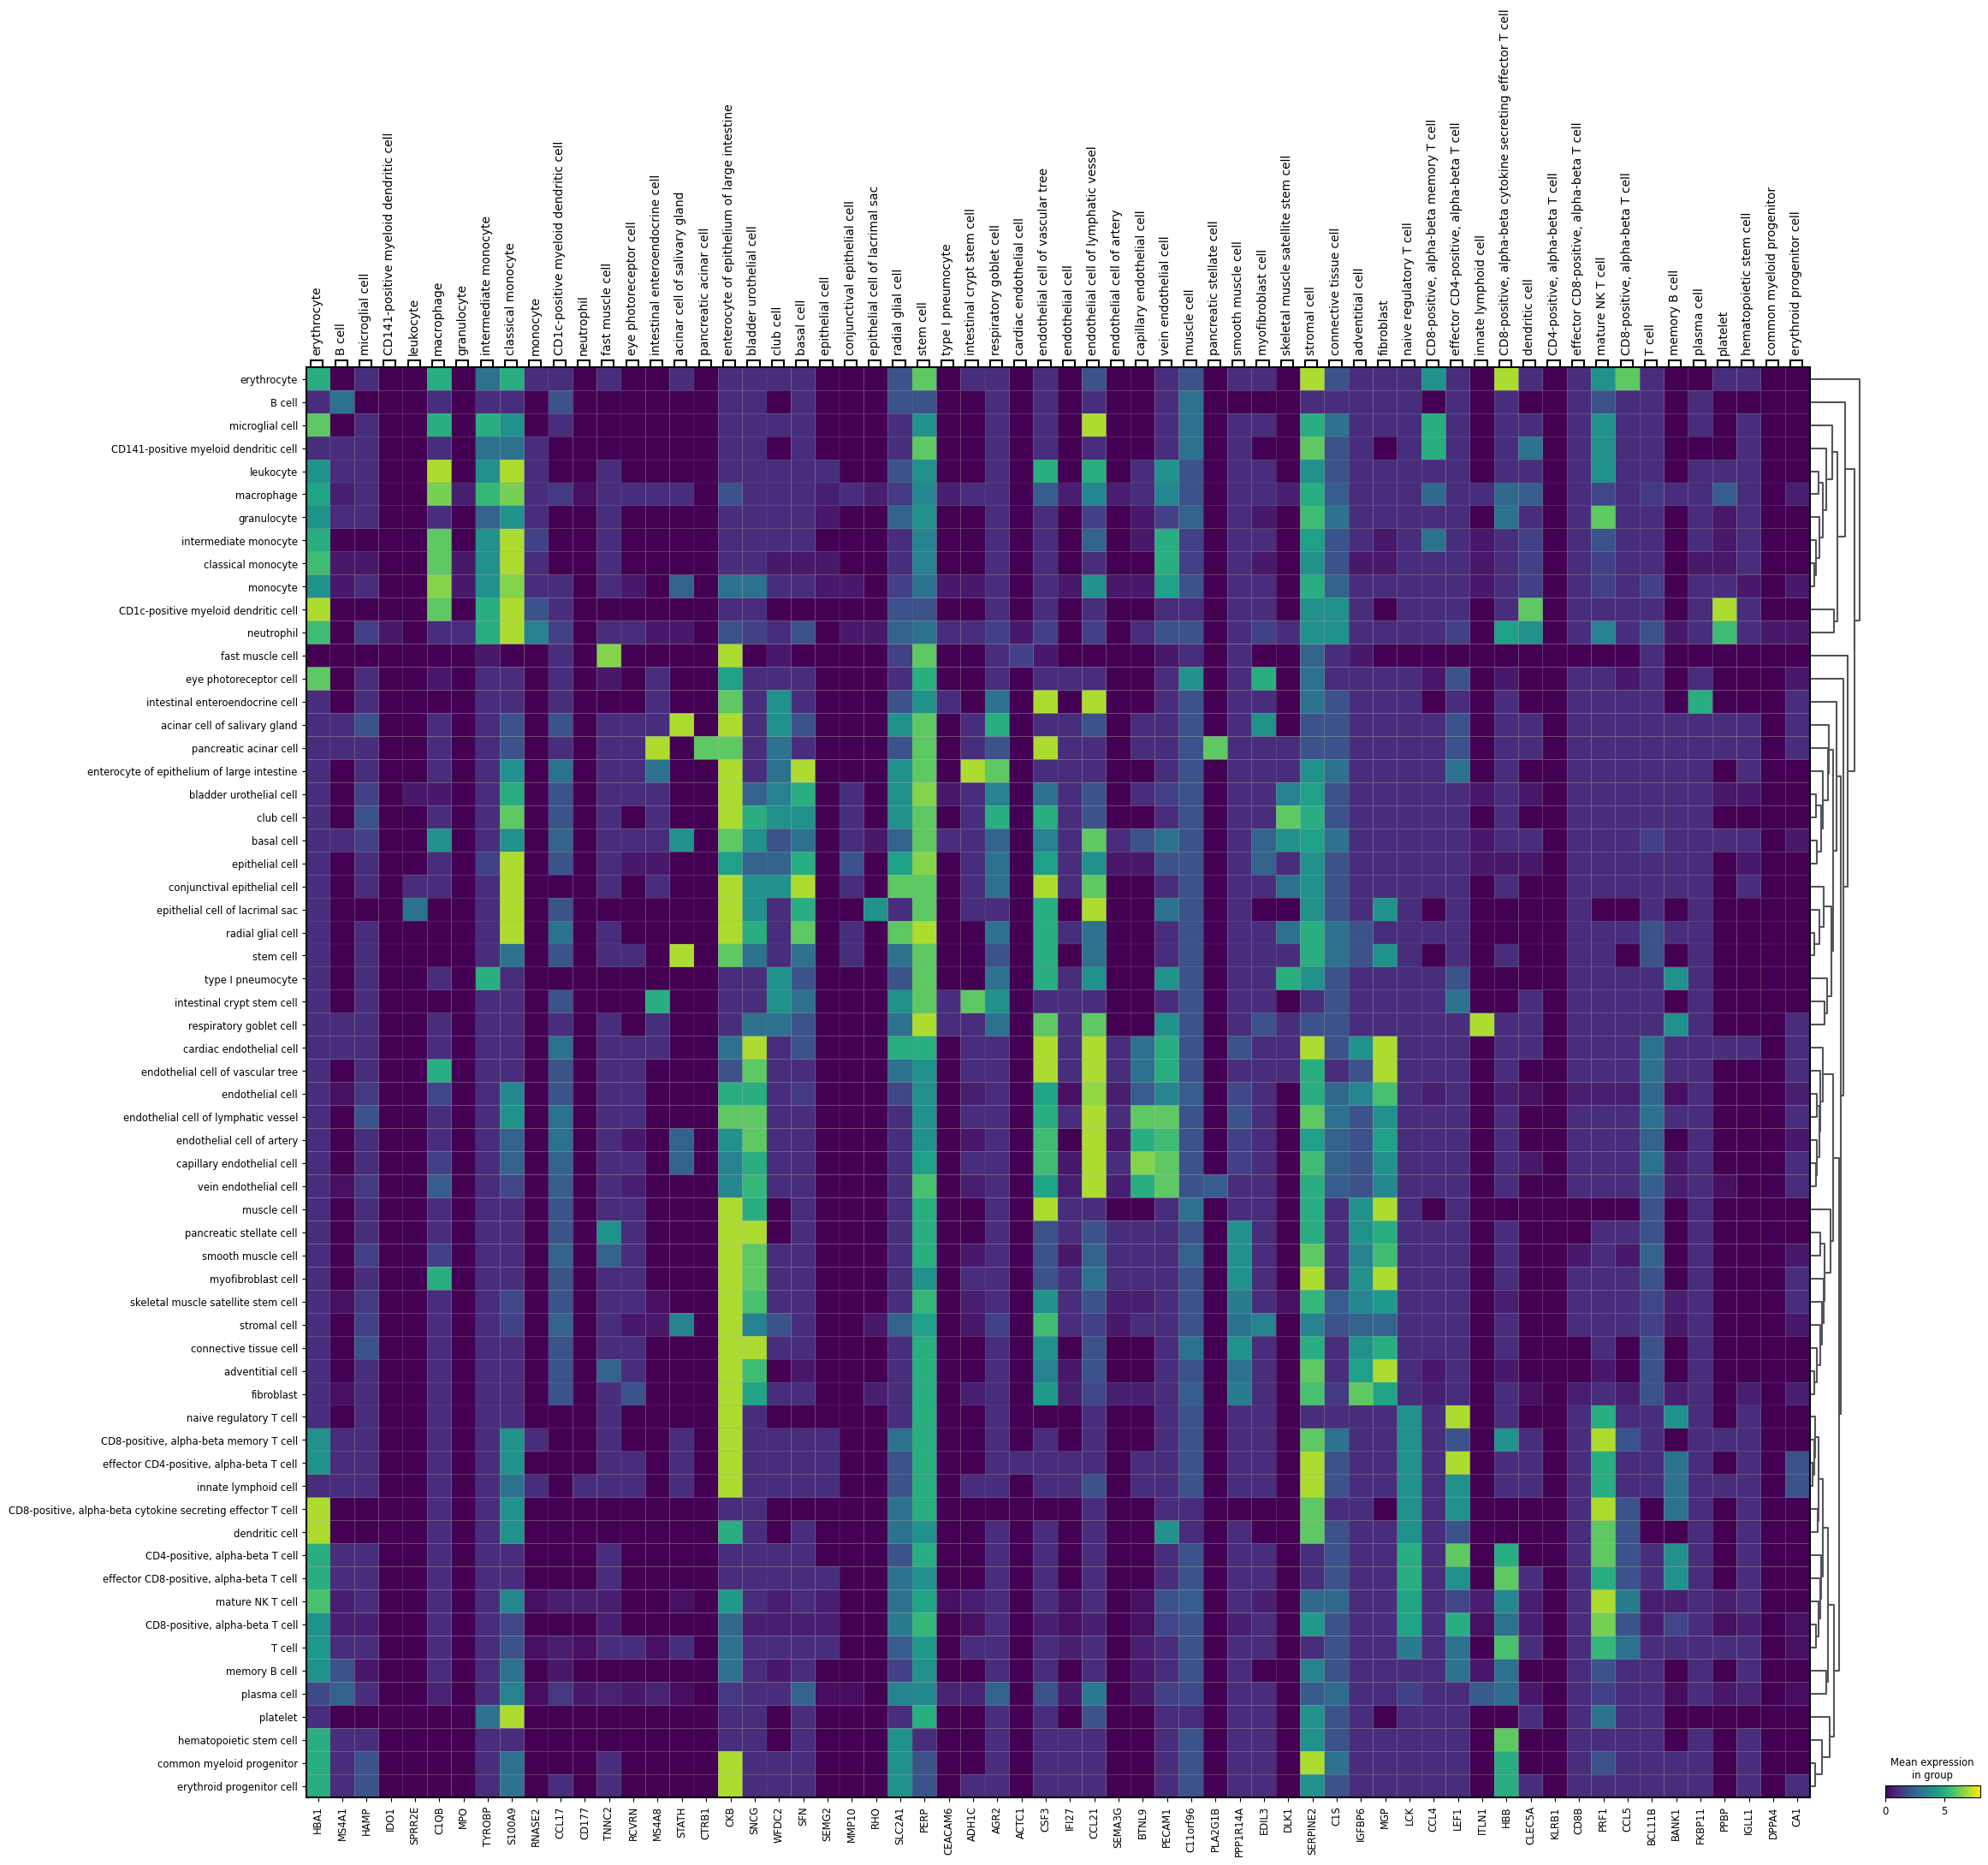

In [62]:
a = sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=8,
    show=False,
    dendrogram=True,
)

In [63]:
adata_predict.layers['predicted'].max()

7

In [52]:
sc.pl._matrixplot.MatrixPlot

scanpy.plotting._matrixplot.MatrixPlot

In [53]:
from scanpy.plotting._matrixplot import MatrixPlot

In [54]:
mp_c = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="confidence",
    vmin=0,
    vmax=6,
    show=False,
    dendrogram=False,
)

In [78]:
mp_p = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="target",
    vmin=0,
    vmax=7,
    show=False,
    dendrogram=True,
)

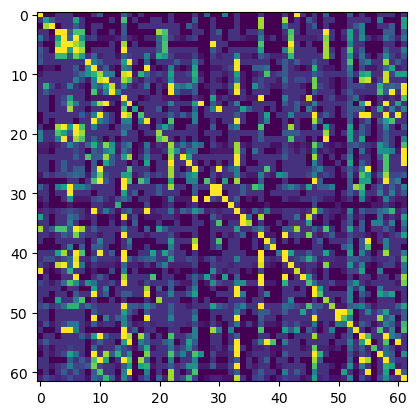

In [79]:
import matplotlib.pyplot as plt
plt.imshow(mp_p.values_df.values)

In [80]:
mp_p.add_dendrogram(dendrogram_key=True)

_color_df = mp_p.values_df.copy()
if mp_p.var_names_idx_order is not None:
    _color_df = _color_df.iloc[:, mp_p.var_names_idx_order]

if mp_p.categories_order is not None:
    _color_df = _color_df.loc[mp_p.categories_order, :]

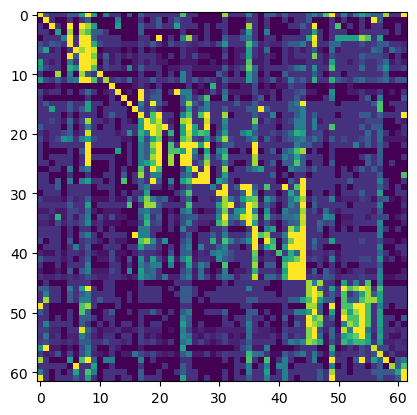

In [81]:
import matplotlib.pyplot as plt

plt.imshow(_color_df)

In [74]:
mp_p.categories_order

['erythrocyte',
 'B cell',
 'microglial cell',
 'CD141-positive myeloid dendritic cell',
 'leukocyte',
 'macrophage',
 'granulocyte',
 'intermediate monocyte',
 'classical monocyte',
 'monocyte',
 'CD1c-positive myeloid dendritic cell',
 'neutrophil',
 'fast muscle cell',
 'eye photoreceptor cell',
 'intestinal enteroendocrine cell',
 'acinar cell of salivary gland',
 'pancreatic acinar cell',
 'enterocyte of epithelium of large intestine',
 'bladder urothelial cell',
 'club cell',
 'basal cell',
 'epithelial cell',
 'conjunctival epithelial cell',
 'epithelial cell of lacrimal sac',
 'radial glial cell',
 'stem cell',
 'type I pneumocyte',
 'intestinal crypt stem cell',
 'respiratory goblet cell',
 'cardiac endothelial cell',
 'endothelial cell of vascular tree',
 'endothelial cell',
 'endothelial cell of lymphatic vessel',
 'endothelial cell of artery',
 'capillary endothelial cell',
 'vein endothelial cell',
 'muscle cell',
 'pancreatic stellate cell',
 'smooth muscle cell',
 'myofi

In [75]:
mp_p.var_names_idx_order

[29,
 0,
 44,
 1,
 40,
 41,
 34,
 37,
 14,
 45,
 2,
 49,
 32,
 31,
 39,
 8,
 50,
 26,
 11,
 15,
 10,
 27,
 17,
 28,
 54,
 58,
 60,
 38,
 55,
 13,
 25,
 22,
 24,
 23,
 12,
 61,
 46,
 51,
 57,
 47,
 56,
 59,
 18,
 9,
 33,
 48,
 6,
 20,
 36,
 5,
 19,
 3,
 21,
 42,
 4,
 7,
 43,
 52,
 53,
 35,
 16,
 30]

In [49]:
adata_predict.obs['label']

TSP5_B cell                                                                  B cell
TSP2_CD141-positive myeloid dendritic cell    CD141-positive myeloid dendritic cell
TSP10_CD1c-positive myeloid dendritic cell     CD1c-positive myeloid dendritic cell
TSP11_CD4-positive, alpha-beta T cell               CD4-positive, alpha-beta T cell
TSP2_CD8-positive, alpha-beta T cell                CD8-positive, alpha-beta T cell
                                                              ...                  
TSP15_stromal cell                                                     stromal cell
TSP2_type I pneumocyte                                            type I pneumocyte
TSP1_vein endothelial cell                                    vein endothelial cell
TSP14_vein endothelial cell                                   vein endothelial cell
TSP4_vein endothelial cell                                    vein endothelial cell
Name: label, Length: 97, dtype: category
Categories (62, object): ['B cell',

In [7]:
import torch

target = torch.from_numpy(adata_predict.layers['target'])
preds = torch.from_numpy(adata_predict.layers['predicted'])
conf = torch.from_numpy(adata_predict.layers['confidence'])
num_classes = adata_predict.uns['nbins']

In [8]:
unique_mapping = target.to(torch.long) * num_classes + preds.to(torch.long)
cm = torch.bincount(unique_mapping.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()

In [9]:
cm_conf = torch.bincount(unique_mapping.ravel(), weights=conf.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()
cm_conf = cm_conf / cm

Text(0.5, 1.0, 'confusion matrix with confidence transparency')

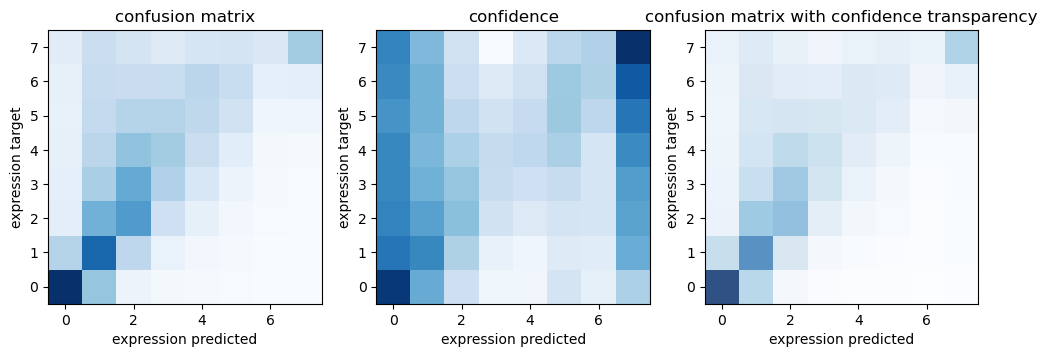

In [46]:
import numpy as np
import matplotlib.pyplot as plt


bins = np.arange(nbins)
xlim = [-0.5, num_classes - 0.5]

_, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={"wspace": 0.2})

# Subplot with confusion matrix
axs[0].imshow(cm / cm.sum(axis=1)[:, np.newaxis], cmap='Blues')
axs[0].set_xlim(xlim)
axs[0].set_ylim(xlim)
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlabel("expression predicted")
axs[0].set_ylabel("expression target")
axs[0].set_title("confusion matrix")

axs[1].imshow(cm_conf, cmap='Blues')
axs[1].set_xlim(xlim)
axs[1].set_ylim(xlim)
axs[1].set_aspect("equal", adjustable="box")
axs[1].set_xlabel("expression predicted")
axs[1].set_ylabel("expression target")
axs[1].set_title("confidence")

axs[2].imshow(cm / cm.sum(axis=1)[:, np.newaxis], alpha=cm_conf, cmap='Blues')
axs[2].set_xlim(xlim)
axs[2].set_ylim(xlim)
axs[2].set_aspect("equal", adjustable="box")
axs[2].set_xlabel("expression predicted")
axs[2].set_ylabel("expression target")
axs[2].set_title("confusion matrix with confidence transparency")

In [11]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [12]:
marker_genes_dict

{'B cell': 'MS4A1',
 'CD141-positive myeloid dendritic cell': 'IDO1',
 'CD1c-positive myeloid dendritic cell': 'CCL17',
 'CD4-positive, alpha-beta T cell': 'KLRB1',
 'CD8-positive, alpha-beta T cell': 'CCL5',
 'CD8-positive, alpha-beta cytokine secreting effector T cell': 'HBB',
 'CD8-positive, alpha-beta memory T cell': 'CCL4',
 'T cell': 'BCL11B',
 'acinar cell of salivary gland': 'STATH',
 'adventitial cell': 'IGFBP6',
 'basal cell': 'SFN',
 'bladder urothelial cell': 'SNCG',
 'capillary endothelial cell': 'BTNL9',
 'cardiac endothelial cell': 'ACTC1',
 'classical monocyte': 'S100A9',
 'club cell': 'WFDC2',
 'common myeloid progenitor': 'DPPA4',
 'conjunctival epithelial cell': 'MMP10',
 'connective tissue cell': 'C1S',
 'dendritic cell': 'CLEC5A',
 'effector CD4-positive, alpha-beta T cell': 'LEF1',
 'effector CD8-positive, alpha-beta T cell': 'CD8B',
 'endothelial cell': 'IFI27',
 'endothelial cell of artery': 'SEMA3G',
 'endothelial cell of lymphatic vessel': 'CCL21',
 'endotheli

In [20]:
adata_predict.obs['cell_type']

TSP5_B cell                                                                  B cell
TSP2_CD141-positive myeloid dendritic cell    CD141-positive myeloid dendritic cell
TSP10_CD1c-positive myeloid dendritic cell     CD1c-positive myeloid dendritic cell
TSP11_CD4-positive, alpha-beta T cell               CD4-positive, alpha-beta T cell
TSP2_CD8-positive, alpha-beta T cell                CD8-positive, alpha-beta T cell
                                                              ...                  
TSP15_stromal cell                                                     stromal cell
TSP2_type I pneumocyte                                            type I pneumocyte
TSP1_vein endothelial cell                                    vein endothelial cell
TSP14_vein endothelial cell                                   vein endothelial cell
TSP4_vein endothelial cell                                    vein endothelial cell
Name: cell_type, Length: 97, dtype: category
Categories (62, object): ['B ce

## Extras

In [ ]:
# import seaborn as sns
# from scipy.cluster.hierarchy import linkage
# import sys


# sys.setrecursionlimit(100000)

In [ ]:
# row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
# col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
# sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)

## Value histograms

In [11]:
import numpy as np

In [14]:
values, counts = np.unique(adata_predict.layers['target'], return_counts=True)

In [15]:
import matplotlib.pyplot as plt

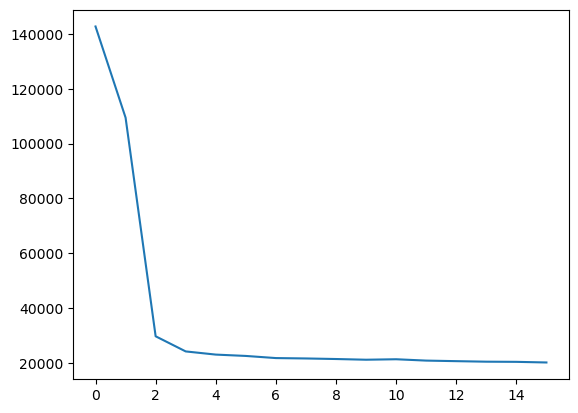

In [16]:
plt.plot(values, counts)

In [17]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [18]:
counts

array([142734, 109481,  29738,  24216,  23059,  22568,  21789,  21648,
        21444,  21187,  21359,  20868,  20665,  20472,  20413,  20183])

In [19]:
import torch

In [20]:
from tqdm import tqdm

In [56]:
adata_predict.layers['counts'][:5, :5]

array([[0.0000e+00, 3.0000e+00, 3.9500e+02, 6.3600e+02, 2.6000e+01],
       [0.0000e+00, 5.9000e+01, 8.7700e+02, 1.8700e+02, 3.5000e+01],
       [0.0000e+00, 6.4500e+02, 4.0300e+02, 6.9000e+01, 2.0000e+00],
       [0.0000e+00, 4.3940e+03, 4.3400e+02, 2.2800e+02, 4.6490e+03],
       [1.0000e+00, 2.0427e+04, 6.0010e+03, 3.1360e+03, 8.2510e+03]],
      dtype=float32)

In [57]:
adata_predict.X[:5, :5]

array([[0.0000000e+00, 3.0287111e-02, 1.6191519e+00, 2.0174453e+00,
        2.3626013e-01],
       [0.0000000e+00, 5.8567297e-01, 2.5521784e+00, 1.2594682e+00,
        3.8684052e-01],
       [0.0000000e+00, 1.0091820e+00, 7.3680979e-01, 1.7100659e-01,
        5.3911968e-03],
       [0.0000000e+00, 2.7412829e+00, 8.8906699e-01, 5.6118375e-01,
        2.7941518e+00],
       [7.4058073e-04, 2.7808945e+00, 1.6948577e+00, 1.2009646e+00,
        1.9618952e+00]], dtype=float32)

In [129]:
full_binned = []
full_boundaries = []

n_bins = 8
for i, row in tqdm(enumerate(adata_predict.X)):
    tensor = torch.Tensor(row)

    boundaries = [torch.tensor(0.0)]
    for q in range(n_bins - 2):
        data_remaining = tensor[tensor>boundaries[-1]]
        n_data_remaining = len(data_remaining)
        if n_data_remaining == 0:
            next_val = boundaries[-1]
        else:
            n_bins_remaining = n_bins - q - 1
            factor = np.exp(np.log(n_data_remaining) / n_bins_remaining)
            next_quantile = 1 / 2
            next_val = max(boundaries[-1]+1e-5, torch.quantile(data_remaining, next_quantile))
            next_val = torch.quantile(data_remaining, next_quantile)
        boundaries.append(next_val)
    boundaries = torch.stack(boundaries, dim=0)

    full_binned.append(torch.bucketize(tensor, boundaries))
    full_boundaries.append(boundaries)
full_binned = torch.cat(full_binned, dim=0)
full_boundaries = torch.stack(full_boundaries)

97it [00:00, 218.53it/s]


In [130]:
full_boundaries[2]

tensor([0.0000, 0.4564, 1.5505, 2.3955, 3.1101, 3.6702, 4.1664])

In [131]:
full_boundaries[2]

tensor([0.0000, 0.4564, 1.5505, 2.3955, 3.1101, 3.6702, 4.1664])

In [132]:
full_boundaries[12]

tensor([0.0000, 0.2938, 0.8156, 1.3745, 1.9998, 2.6167, 3.2020])

In [133]:
full_boundaries[:, -1]

tensor([4.3161, 4.2326, 4.1664, 3.9993, 3.9786, 4.3486, 3.9978, 4.4019, 3.9719,
        4.0525, 3.9884, 3.9456, 3.2020, 4.1890, 4.1465, 3.8070, 3.9962, 3.7649,
        4.1978, 4.1337, 4.1600, 3.8903, 4.0302, 4.1943, 3.8770, 3.8656, 4.1491,
        4.0520, 4.3515, 3.8009, 4.0531, 4.1757, 3.9002, 3.9551, 4.0438, 4.1490,
        4.0373, 4.1005, 3.4571, 4.2474, 3.8134, 4.7266, 2.3986, 3.8582, 4.1021,
        4.2524, 4.2919, 4.8861, 4.0300, 3.8965, 4.0624, 4.0952, 4.1487, 3.9828,
        3.6180, 4.3060, 4.3220, 3.9540, 3.9855, 4.0906, 4.0493, 4.0576, 4.1036,
        3.9221, 4.1769, 3.9890, 4.0975, 4.4038, 4.2879, 3.9929, 3.9871, 4.2571,
        4.1370, 4.0859, 3.8877, 4.0021, 3.1752, 4.1024, 3.8391, 4.3199, 4.0000,
        4.1586, 4.5724, 4.0754, 3.7501, 3.8639, 4.1546, 4.0720, 3.9877, 4.0414,
        4.0251, 3.9234, 3.2611, 4.3458, 4.1813, 3.8417, 4.2187])

In [134]:
values, counts = torch.unique(full_binned, return_counts=True)

In [135]:
print(values)
print(counts)

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([142734, 210431, 104592,  52115,  26029,  12991,   6497,   6435])


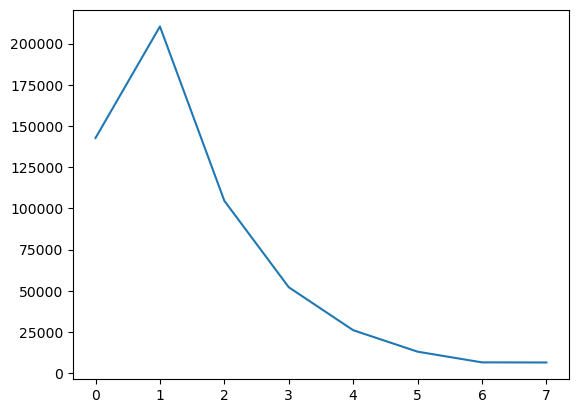

In [136]:
plt.plot(counts)

In [110]:
len(row)

5792

In [79]:
x = np.exp(np.log(5792) / 16)

In [84]:
5792 / x**15

1.7186078239135654

In [21]:
import numpy as np
from scipy.optimize import minimize_scalar

def geometric_series_r(n, Q):
    def series_sum(r):
        return (1 - r**n) / (1 - r) - Q

    res = minimize_scalar(series_sum, bounds=(0, 1), method='bounded')
    return res.x

n = 5  # Number of steps
Q = 12005  # Sum of the geometric series

r = geometric_series_r(n, Q)
print(f"Approximate value of r: {r:.5f}")


Approximate value of r: 0.00001


In [18]:
geometric_series_r(16, 5792)

4.439545990918005e-06

In [19]:
4.439545990918005e-06 + 4.439545990918005e-06^2

TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [ ]:
plt.plot(values, counts)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
nbins = self.transform[-1].n_bins
bin_counts = torch.zeros(nbins, dtype=torch.long)
bin_counts[values] = counts
mask_indices = torch.multinomial(1 / bin_counts[expression], int(self.mask * len(expression)))
mask = torch.zeros(expression.shape, dtype=torch.bool)
mask[mask_indices] = True

mask_type = torch.rand(1)
if mask_type < self.pass_through:
    pass
elif mask_type < self.corrupt:
    count_inds = torch.multinomial(counts, len(mask_indices))
    expression[mask] = values[count_inds]

In [ ]:
if torch.rand(1) < 0.3:
    print('a')

## Scanpy plots

In [ ]:
import scanpy as sc

In [ ]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer=None,
    vmin=0,
    vmax=1e2,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='confidence',
    vmin=0,
    vmax=1,
    show=False,
    title='confidence',
    dendrogram=True,
)

In [ ]:
sc.pl.dotplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
marker_genes_dict_2 = {}

for key, value in list(marker_genes_dict.items())[:20]:
    marker_genes_dict_2[key] = value

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="measured",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes['heatmap_ax'].clear()

In [ ]:
for a in axes['heatmap_ax'].lines:
    print(a)

In [ ]:
axes

In [ ]:
del axes['gene_groups_ax']

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)